# Model assembly

Wir entschieden uns ein Neuronales Netz zu benutzen, da es uns ermöglicht durch Maschinelles Lernen eine automatische Gewichtung der verschiedenen Eingangsstatistiken zu bestimmen.

## Modellimplementierung

### Imports
Importiert die Bibliotheken PyTorch und Pandas, sowie Matplotlib um Lernkurven graphisch darzustellen.

In [1]:
import time
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

### Device
Bestimmt ob auf der Grafikkarte oder auf dem Prozessor gerechnet werden soll. Wenn eine CUDA fähige Grafikkarte erkannt wird, wird diese als Rechengerät ausgewählt. Dies spart Rechenzeit, da CUDA Kerne deutlich effizienter in der Berechnung Neuronaler Netze sind.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### PyTorch Klassen
Definiert eine Klasse für das Datenset und eine für das Neuronale Netzwerk.

In [3]:
class LolProDataset(Dataset):
    def __init__(self, data_file):
        # Preload data into tensors
        data = pd.read_csv(data_file)
        self.labels = torch.tensor(data.pop('Win Rate').to_numpy(), device=device)
        self.features = torch.tensor(data.to_numpy(), device=device)

    def __len__(self):
        # Number of rows in the dataset
        return self.features.shape[0]

    def __getitem__(self, idx):
        # Returns item (features, label) at specific index
        x = self.features[idx]
        y = self.labels[idx]
        return (x, y)

    def split(self, test_rate):
        # Returns number of items for test and train sets by given test_rate
        testc = int(self.__len__()*test_rate)
        trainc = int(self.__len__() - testc)
        return [trainc, testc]

# This is just a wrapper for the network_stack which implements the Neural Network
class LolProNetwork(nn.Module):
    def __init__(self, network_stack):
        super(LolProNetwork, self).__init__()
        self.network_stack = network_stack

    def forward(self, x):
        return self.network_stack(x)

### Train and Test Loops
Zwei Schleifen, eine für das Training über das das Datenset iteriert und Anpassungen am Modell vornimmt und eine Test Schleife, die diese Anpassungen statistisch festhält um diese zu bewerten.

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Train Loop: trains the Neural Network
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(dataloader, model, loss_fn, optimizer):
    # Test Loop: Tests the Neural Network
    size = len(dataloader.dataset)
    test_loss, err = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            err += torch.abs(pred - y.unsqueeze(1)).sum().data
    test_loss /= size
    err /= size
    return (err.item(), test_loss)

### Run Code
Set parameters, define Network, loss function and optimizer, load in Dataset and train the network

In [5]:
lr = 0.0001 # Learning Rate
batch_size = 10 # Batch Size (Parallel calculated rows)
epochs = 300 # Epochs (iterations over dataset)

# Network
network_stack = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Sigmoid(),
    nn.Linear(19, 8),
    nn.PReLU(),
    nn.Linear(8, 1),
    nn.Softsign()
)

# Generate Model from Network and push it to the specified device and set dtype to double
model = LolProNetwork(network_stack).to(device).double()

loss_fn = nn.L1Loss() # MAE Loss function
optimizer = torch.optim.Adam(model.parameters(), lr) # Optimizer

# Load Dataset
dataset = LolProDataset('cleanData.csv')
train_data, test_data = random_split(dataset, dataset.split(0.1), generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Train and test in epochs
history = pd.DataFrame([], columns=["Epoch", "MAE", "Loss"])
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    res = test_loop(test_dataloader, model, loss_fn, optimizer)
    history = history.append({"Epoch": t+1, "MAE": res[0], "Loss": res[1]}, ignore_index=True)
    if (t+1)%100 == 0:
        print(f"Epoch {t+1} - MAE: {res[0]}, Loss: {res[1]}")

Epoch 100 - MAE: 0.11256264550112877, Loss: 0.011389441058978746
Epoch 200 - MAE: 0.11760106841120146, Loss: 0.011926338873338858
Epoch 300 - MAE: 0.11530273104599208, Loss: 0.011670567873008186


### Visualize results
Mithilfe von Matplotlib können die Ergebnisse graphisch dargestellt werden.

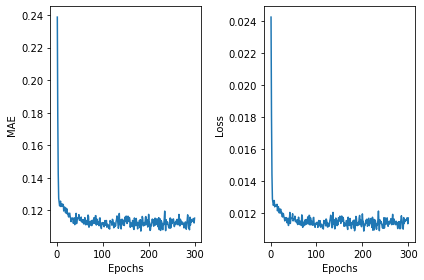

In [6]:
def plotit(history):
    fig, axs = plt.subplots(1, 2)

    axs[0].plot(history['Epoch'], history['MAE'])
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("MAE")
    axs[1].plot(history['Epoch'], history['Loss'])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    fig.tight_layout()

    plt.show()
plotit(history)

Diese Ergebnisse sehen schon ganz gut aus. Es ist eine deutliche Lernkurve zu erkennen und ein Ergebnis von ca. 89 % Genauigkeit ist auch in Ordnung. Das können wir jedoch noch verbessern!

## Grid Search

Um eine bessere Architektur und bessere Parameter für das Training zu finden benutzen wir eine Grid-Suche, welche verschiedene Kombinationen aus-testet und die Ergebnisse für spätere Analyse speichert. Hierzu implementieren wir eine Trainer Funktion, welche die verschiedenen Netzwerke und Hyperparameter als Parameter entgegen nimmt und diese austestet.

In [ ]:
def trainer(lr, batch_size, epochs, network, opt, dataset):
    model = LolProNetwork(network).to(device).double()
    loss_fn = nn.L1Loss() # MAE Loss function
    optimizer = opt(model.parameters(), lr) # Optimizer

    dataset = LolProDataset(dataset)
    train_data, test_data = random_split(dataset, dataset.split(0.1), generator=torch.Generator().manual_seed(42))
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    history = pd.DataFrame([], columns=["Epoch", "MAE", "Loss"])

    print("\n-----------------------------------")
    print(f"\nStart Training with the Parameters:\nlearning rate: {lr}\nbatch size: {batch_size}\nepochs: {epochs}\noptimizer: {optimizer}\nnetwork: {network}\n")
    for t in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer)
        res = test_loop(test_dataloader, model, loss_fn, optimizer)
        history = history.append({"Epoch": t+1, "MAE": res[0], "Loss": res[1]}, ignore_index=True)
    
    print(f"\nSmallest MAE at index {history['MAE'].idxmin()} with:\n{history['MAE'].min()}\n")
    plotit(history)
    print("-----------------------------------\n")
    return (model, history)


Nun iterieren wir über verschiedene Parameter um die verschiedenen Kombinationen mit der Trainer Funktion testen zu lassen. Dies dauert eine Weile, da jedes Training seine Zeit braucht.


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 15
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 1 with:
0.40382719589109783



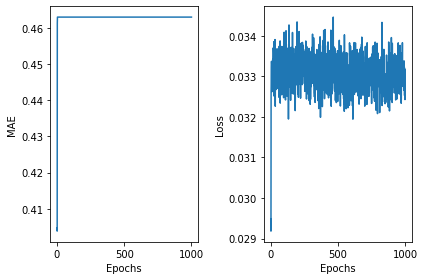

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 15
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 30 with:
0.46300595238095227



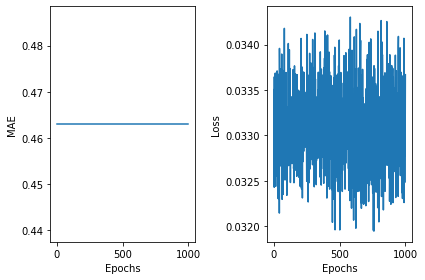

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 15
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 12 with:
0.46300595238095227



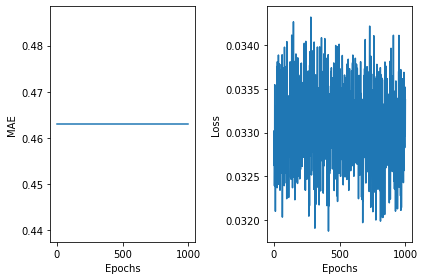

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 15
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 36 with:
0.46300595238095227



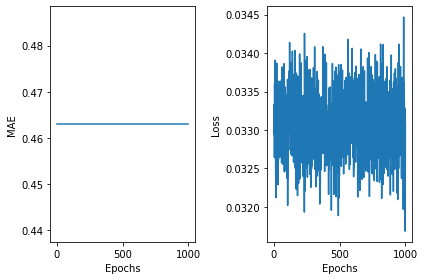

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 45
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



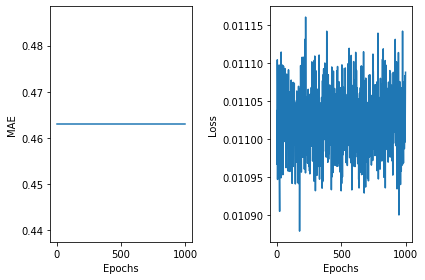

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 45
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



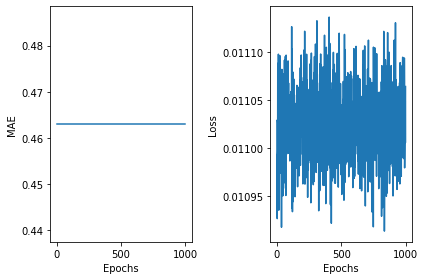

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 45
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 175 with:
0.46300595238095227



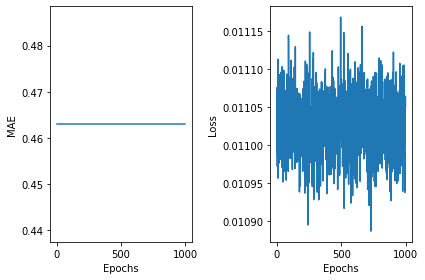

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 45
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



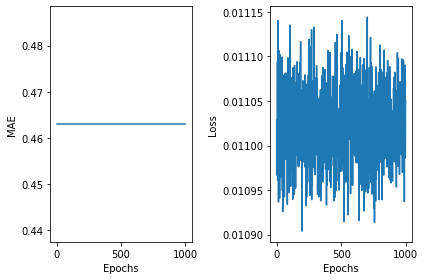

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 90
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



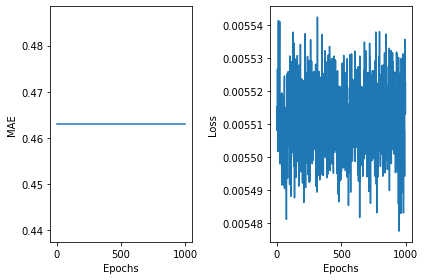

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 90
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



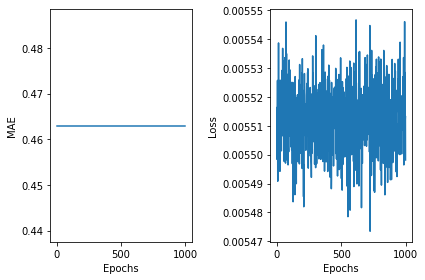

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 90
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



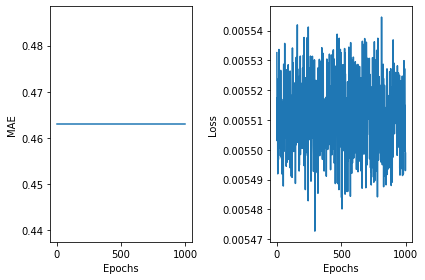

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.005
batch size: 90
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



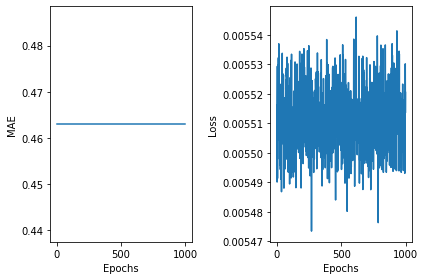

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 15
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 15 with:
0.46300595238095227



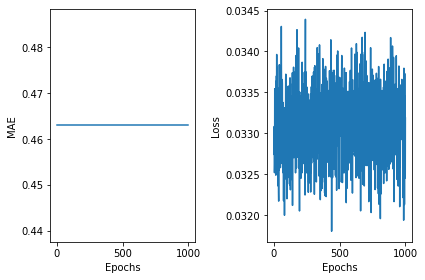

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 15
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 840 with:
0.46300595238095216



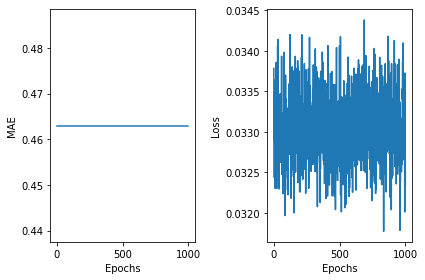

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 15
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.46300595238095227



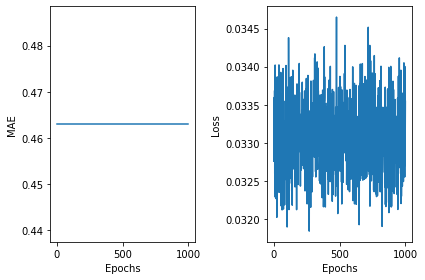

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 15
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 804 with:
0.46300595238095216



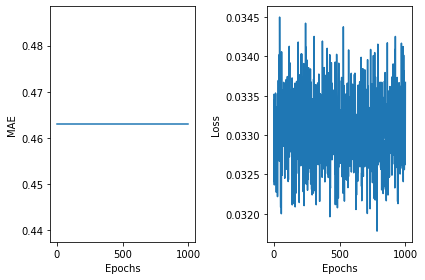

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 45
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 85 with:
0.46300595238095227



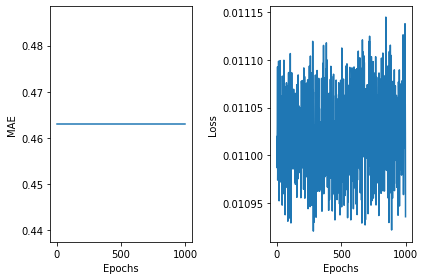

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 45
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 157 with:
0.46300595238095227



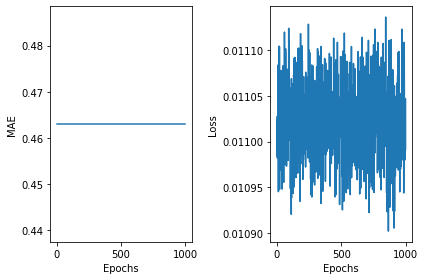

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 45
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 479 with:
0.46300595238095227



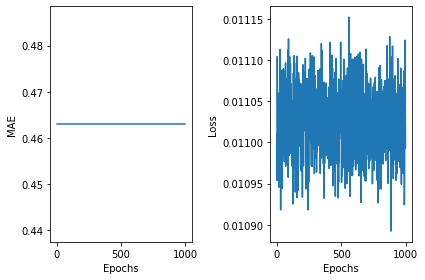

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 45
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 567 with:
0.46300595238095227



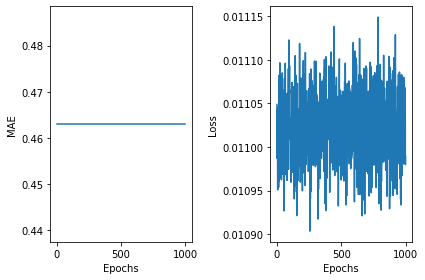

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 90
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



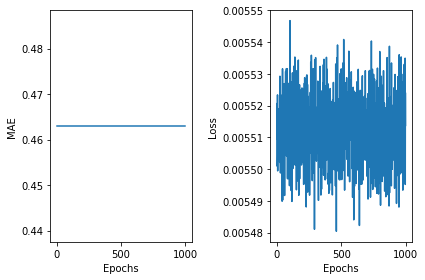

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 90
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 2 with:
0.4630059523809523



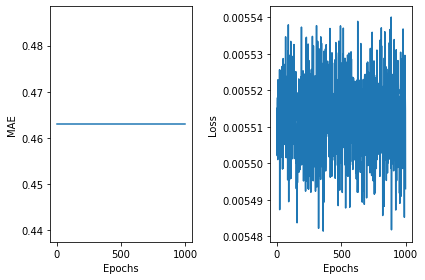

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 90
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



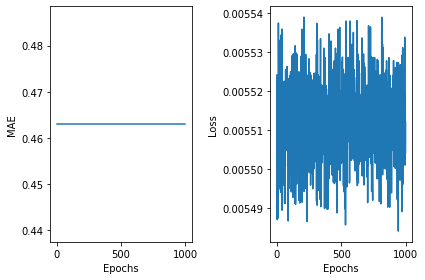

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 0.0005
batch size: 90
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0005
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 1 with:
0.4630059523809523



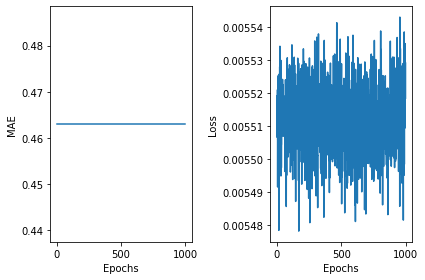

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 15
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.46300595238095227



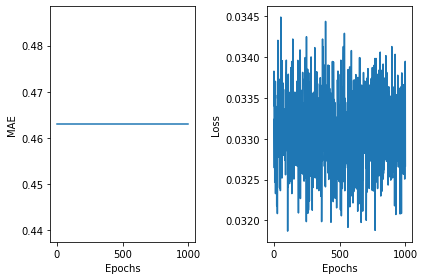

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 15
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 28 with:
0.46300595238095227



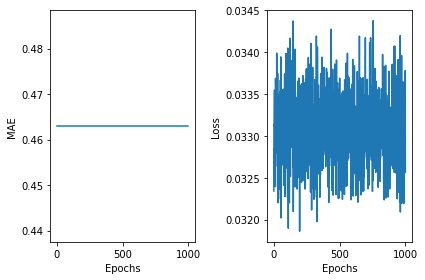

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 15
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 249 with:
0.46300595238095216



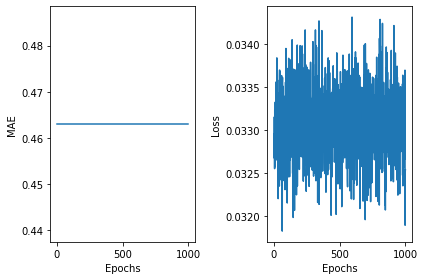

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 15
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 3 with:
0.46300595238095227



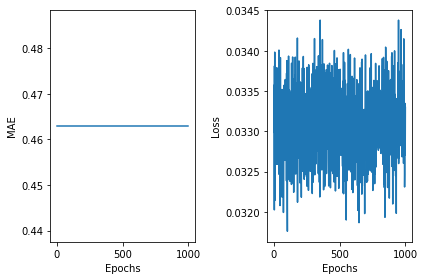

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 45
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 450 with:
0.46300595238095227



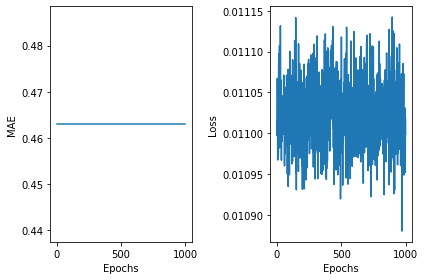

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 45
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 94 with:
0.46300595238095227



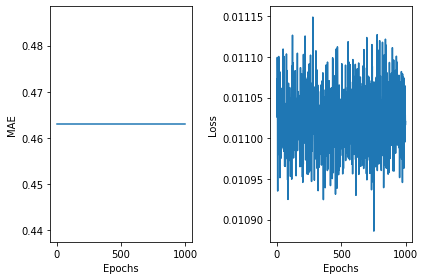

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 45
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 584 with:
0.46300595238095227



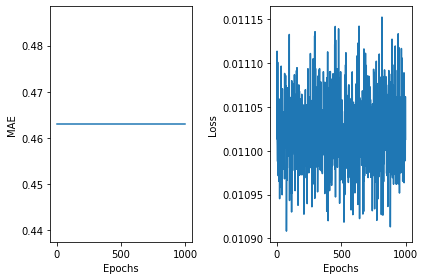

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 45
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



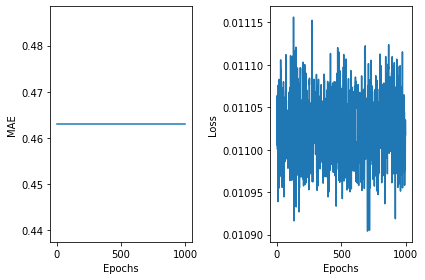

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 90
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



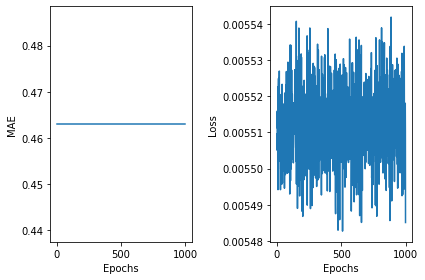

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 90
epochs: 1000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



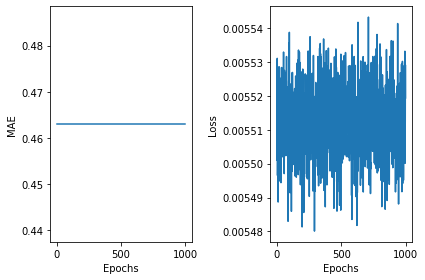

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 90
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



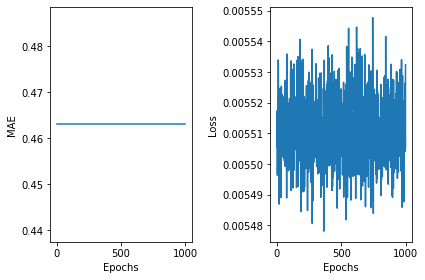

-----------------------------------


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 90
epochs: 1000
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 0 with:
0.4630059523809523



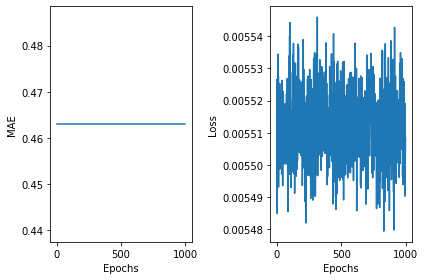

-----------------------------------



,Learning Rate,Batch Size,Epochs,Optimizer,Network,History,Min MAE,Idx Min MAE,Duration
0,0.00500,15,1000,<class 'torch.optim.adam.Adam'>,"[Linear(in_features=19, out_features=5, bias=T...",Epoch MAE Loss 0 1.0 0...,0.403827,1,86679.198027
1,0.00500,15,1000,<class 'torch.optim.adam.Adam'>,"[Linear(in_features=19, out_features=64, bias=...",Epoch MAE Loss 0 1.0 0...,0.463006,30,86222.535849
2,0.00500,15,1000,<class 'torch.optim.sgd.SGD'>,"[Linear(in_features=19, out_features=5, bias=T...",Epoch MAE Loss 0 1.0 0...,0.463006,12,66265.008926
3,0.00500,15,1000,<class 'torch.optim.sgd.SGD'>,"[Linear(in_features=19, out_features=64, bias=...",Epoch MAE Loss 0 1.0 0...,0.463006,36,64404.659271
4,0.00500,45,1000,<class 'torch.optim.adam.Adam'>,"[Linear(in_features=19, out_features=5, bias=T...",Epoch MAE Loss 0 1.0 0...,0.463006,0,32889.001608
5,0.00500,45,1000,<class 'torch.optim.adam.Adam'>,"[Linear(in_features=19, out_features=64, bias=...",Epoch MAE Loss 0 1.0 0...,0.463006,0,33082.000494
6,0.00500,45,1000,<class 'torch.optim.sgd.SGD'>,"[Linear(in_features=19, out_features=5, bias=T...",Epoch MAE Loss 0 1.0 0...,0.463006,175,27098.703623
7,0.00500,45,1000,<class 'torch.optim.sgd.SGD'>,"[Linear(in_features=19, out_features=64, bias=...",Epoch MAE Loss 0 1.0 0...,0.463006,0,26917.950869
8,0.00500,90,1000,<class 'torch.optim.adam.Adam'>,"[Linear(in_features=19, out_features=5, bias=T...",Epoch MAE Loss 0 1.0 0...,0.463006,0,20287.998199
9,0.00500,90,1000,<class 'torch.optim.adam.Adam'>,"[Linear(in_features=19, out_features=64, bias=...",Epoch MAE Loss 0 1.0 0...,0.463006,0,20371.299982


In [8]:
learning_rates = [0.005, 0.0005, 0.00005]
batch_sizes = [15, 45, 90]
e = 1000
optimizer = [torch.optim.Adam, torch.optim.SGD]
networks = [
    nn.Sequential(
        nn.Linear(19, 5),
        nn.CELU(),
        nn.Linear(5, 1),
        nn.Sigmoid()
    ),
    nn.Sequential(
        nn.Linear(19, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )
]

results = pd.DataFrame([], columns=["Learning Rate", "Batch Size", "Epochs", "Optimizer", "Network", "History", "Min MAE", "Idx Min MAE", "Duration"])
 
for lr in learning_rates:
    for bs in batch_sizes:
        if bs == 1 or bs == 10:
            continue
        for opt in optimizer:
            for net in networks:
                stime = time.time()
                mod, res = trainer(lr, bs, e, net, opt, 'cleanData.csv')
                etime = time.time()
                results = results.append({
                    "Learning Rate": lr,
                    "Batch Size": bs,
                    "Epochs": e,
                    "Optimizer": opt,
                    "Network": net,
                    "History": res,
                    "Min MAE": res['MAE'].min(),
                    "Idx Min MAE": res['MAE'].idxmin(),
                    "Duration": (etime - stime) * 1000
                }, ignore_index=True)
results.to_pickle('grid_search_results')
results

Mithilfe von Pandas können wir uns das beste Ergebnis ausgeben lassen.

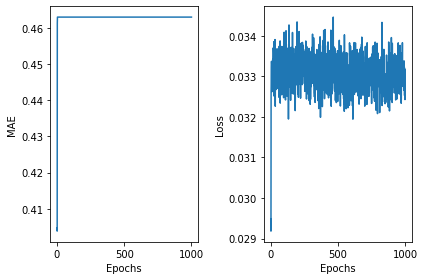

0.40382719589109783

In [10]:
plotit(results.iloc[results['Min MAE'].idxmin()]['History'])
results['Min MAE'].min()

Ein Blick über andere Kombination verrät jedoch, dass andere Kombinationen eventuell viel versprechender sein können als diese, wenn wir sie ein wenig länger Trainieren lassen.


-----------------------------------

Start Training with the Parameters:
learning rate: 5e-05
batch size: 45
epochs: 3000
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
network: Sequential(
  (0): Linear(in_features=19, out_features=5, bias=True)
  (1): CELU(alpha=1.0)
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


Smallest MAE at index 2955 with:
0.0758926825924525



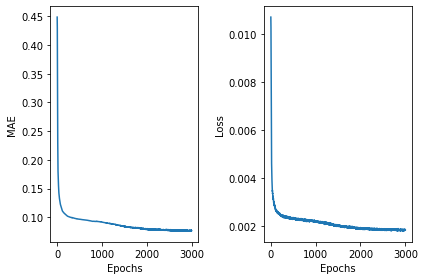

-----------------------------------



In [13]:
lr = 0.00005 # Learning Rate
batch_size = 45 # Batch Size (Parallel calculated rows)
epochs = 3000 # Epochs (iterations over dataset)

# Network
network_stack = nn.Sequential(
    nn.Linear(19, 5),
    nn.CELU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)

model, history = trainer(lr, batch_size, epochs, network_stack, torch.optim.Adam, 'cleanData.csv')

In [ ]:
Das sieht schon besser aus. Durch mehr Epochen konnte das Netzwerk immer besser werden. Der Trainingseffekt nimmt jedoch nach einiger Zeit ab und es besteht die Gefahr eines Overfittings. Daher sind 3000 Epochen perfekt für unsere Zwecke.

## Beispiel

In [ ]:
idx = 0
data = pd.read_csv('cleanData.csv')
rates = data.pop('Win Rate')
t1 = torch.tensor(data.iloc[idx].to_numpy(), device=device).double().unsqueeze(0)
t1

In [ ]:
rates.iloc[idx]

In [ ]:
model(t1).item()

## Modell speichern

Um das Modell in einem Webserver oder ähnlichem wieder zu verwenden möchten wir es speichern. Dazu nutzen wir

In [14]:
torch.save(model.state_dict(), './model/lol_predicter_v1')